<a href="https://colab.research.google.com/github/SoundaryaDube/NeuralNetwork/blob/main/EPICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wfdb numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 4.9 MB/s eta 0:00:00


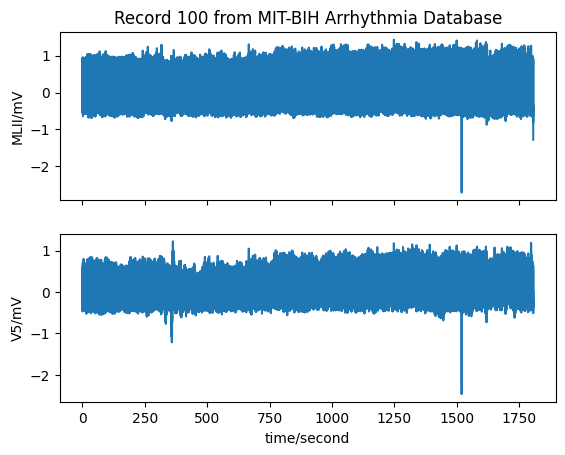

In [20]:
# Correct way to load a record from PhysioNet
record = wfdb.rdrecord('100', pn_dir='mitdb')  # 'mitdb' is the MIT-BIH Arrhythmia dataset
wfdb.plot_wfdb(record=record, title='Record 100 from MIT-BIH Arrhythmia Database')



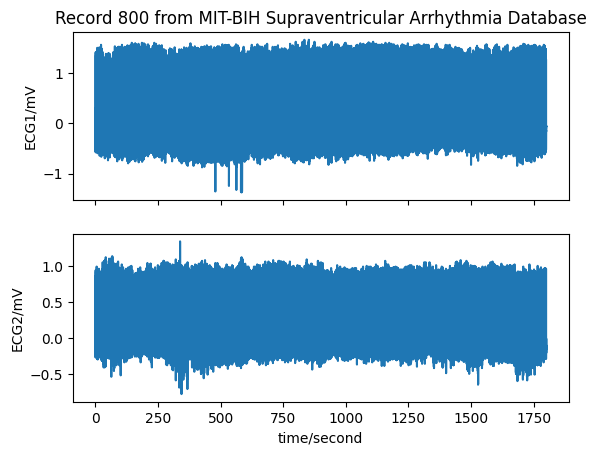

In [23]:
# Load a record from the MIT-BIH Supraventricular Arrhythmia Database
record = wfdb.rdrecord('800', pn_dir='svdb')  # Replace '800' with the desired record ID
wfdb.plot_wfdb(record=record, title='Record 800 from MIT-BIH Supraventricular Arrhythmia Database')


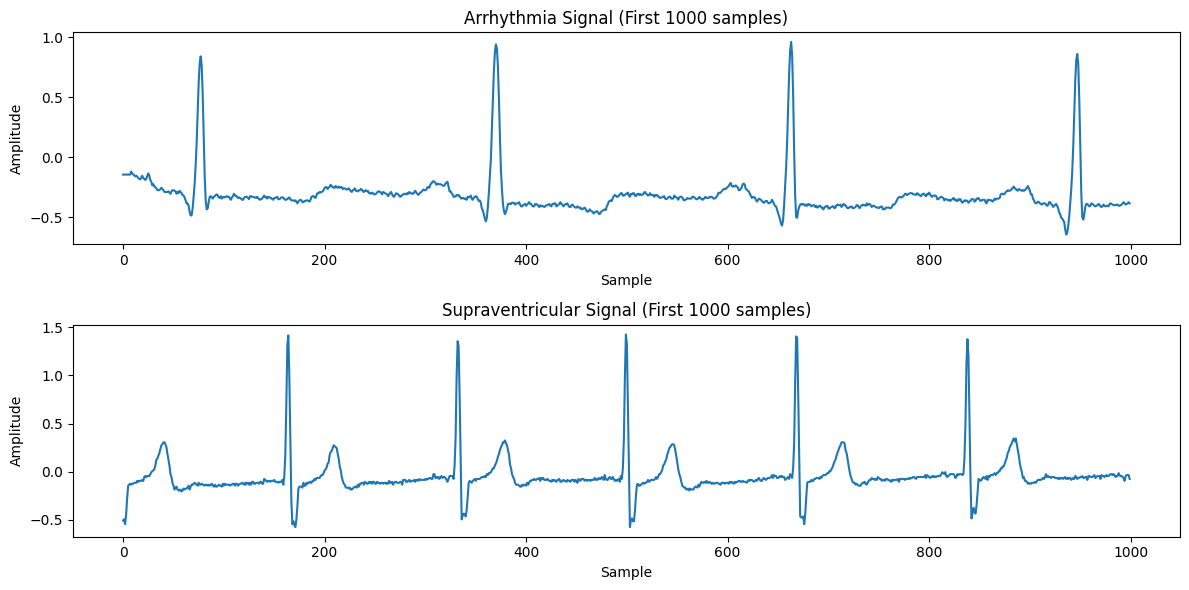

In [26]:
import wfdb
import matplotlib.pyplot as plt

# Read ECG records from PhysioNet
arrhythmia_record = wfdb.rdrecord('100', pn_dir='mitdb')  # MIT-BIH Arrhythmia Database
supraventricular_record = wfdb.rdrecord('800', pn_dir='svdb')  # Supraventricular Arrhythmia Database

# Extract signals
arrhythmia_signals = arrhythmia_record.p_signal
supraventricular_signals = supraventricular_record.p_signal

# Plot signals from the first channel of each dataset
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(arrhythmia_signals[:1000, 0])
plt.title("Arrhythmia Signal (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(supraventricular_signals[:1000, 0])
plt.title("Supraventricular Signal (First 1000 samples)")
plt.xlabel("Sample")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [27]:
import numpy as np

# Normalize signals
def normalize(signal):
    return (signal - np.mean(signal)) / np.std(signal)

# Segment signals into fixed-length windows
def segment_signal(signal, segment_length):
    return [signal[i:i + segment_length] for i in range(0, len(signal) - segment_length, segment_length)]

# Apply preprocessing
segment_length = 360  # 1 second at 360 Hz
normalized_signal = normalize(arrhythmia_signals[:, 0])
segments = segment_signal(normalized_signal, segment_length)

print(f"Number of segments: {len(segments)}")


Number of segments: 1805


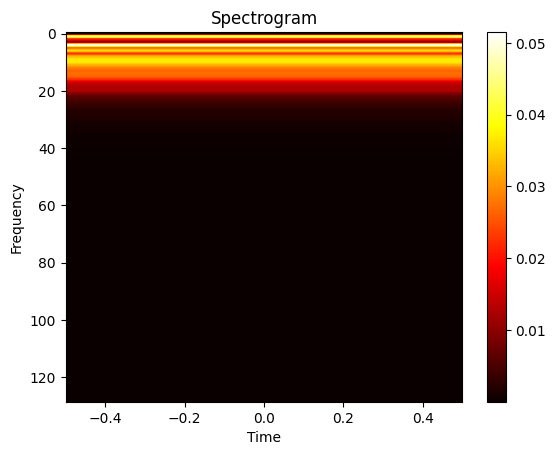

In [28]:
from scipy.signal import spectrogram

# Convert a segment to a spectrogram
def signal_to_spectrogram(segment):
    f, t, Sxx = spectrogram(segment, fs=360)  # Sampling frequency
    return Sxx

# Generate a spectrogram for the first segment
spectrogram_image = signal_to_spectrogram(segments[0])

# Plot the spectrogram
plt.imshow(spectrogram_image, aspect='auto', cmap='hot')
plt.title("Spectrogram")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()


In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define CNN model
def build_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example Input Shape (e.g., 128x128 spectrograms with 1 channel)
input_shape = (128, 128, 1)
num_classes = 5  # For example: arrhythmia, atrial fibrillation, etc.
cnn_model = build_cnn(input_shape, num_classes)

# Summary of the model
cnn_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,938,501 (49.36 MB)

 Trainable params: 12,938,501 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Define LSTM model
def build_lstm(input_shape, num_classes):
    model = models.Sequential([
        layers.LSTM(128, input_shape=input_shape, return_sequences=True),
        layers.LSTM(64, return_sequences=False),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Example Input Shape (e.g., 360 samples per segment, 1 feature per sample)
input_shape = (360, 1)
num_classes = 5
lstm_model = build_lstm(input_shape, num_classes)

# Summary of the model
lstm_model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 360, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 120,453 (470.52 KB)

 Trainable params: 120,453 (470.52 KB)

 Non-trainable params: 0 (0.00 B)